# Transfer Learning PyTorch

Following [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
from __future__ import division, print_function
import copy
import os
import time
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [3]:
plt.ion()

In [2]:
# augmentations/normalizations, which will be applied to the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# load images
data_dir = Path('./hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# customized training and evaluation 
# keep track of parameters

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, path='saved_model.pt'):
    
    train_loss, train_acc, val_loss, val_acc = [], [], [], [] 
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch = 0
    
    # load former checkpoint data
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']

    for epoch in range(epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:

            if phase == 'train':
                # Set model to training mode
                model.train()
            else:
               # Set model to evaluation mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward, track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
                # save best model so far as a checkpoint
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_acc': best_acc
                        }, path)
            else: 
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss,train_acc, val_loss, val_acc

In [6]:
# convert tensor to image and display

def imshow(inp, title=None):
    """Overwritten Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
# send validation images through model
# display image + prediction

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

In [8]:
# visualize accuracy and loss datapoints

def visualize_performance(train_loss, train_acc, val_loss, val_acc):
    fig = plt.figure()
    plt.plot(val_acc)
    plt.plot(val_loss)
    plt.plot(train_acc)
    plt.plot(train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('%')
    plt.legend(['Val Acc', 'Val Loss', 'Train Acc', 'Train Loss'])

## Finetuning a ResNet

This first way of TL uses a pre-trained model and updates all layers' parameters to teach the ResNet the difference between ants and bees.

In [33]:
# instantiate a ResNet 
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# add a fresh fully-connected layer on top
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
ft_exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [40]:
# Train new fc-layer of ResNet model
model_ft, train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft = train_model(model_ft, criterion_ft, optimizer_ft, ft_exp_lr_scheduler,
                       num_epochs=25, path='ft_ant_bees_2.pt')

Epoch 3/25
----------
train Loss: 0.4419 Acc: 0.8156
val Loss: 0.3314 Acc: 0.8562

Epoch 4/25
----------
train Loss: 0.5175 Acc: 0.7787
val Loss: 0.2027 Acc: 0.9281

Epoch 5/25
----------
train Loss: 0.6272 Acc: 0.8156
val Loss: 0.2170 Acc: 0.9281

Epoch 6/25
----------
train Loss: 0.3945 Acc: 0.8361
val Loss: 0.2200 Acc: 0.9281

Epoch 7/25
----------
train Loss: 0.3389 Acc: 0.8730
val Loss: 0.1998 Acc: 0.9216

Epoch 8/25
----------
train Loss: 0.4077 Acc: 0.8525
val Loss: 0.2012 Acc: 0.9281

Epoch 9/25
----------
train Loss: 0.4152 Acc: 0.8033
val Loss: 0.2117 Acc: 0.9216

Epoch 10/25
----------
train Loss: 0.2223 Acc: 0.9139
val Loss: 0.2062 Acc: 0.9346

Epoch 11/25
----------
train Loss: 0.3477 Acc: 0.8525
val Loss: 0.2071 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.1997 Acc: 0.9221
val Loss: 0.2073 Acc: 0.9085

Epoch 13/25
----------
train Loss: 0.2989 Acc: 0.8566
val Loss: 0.1915 Acc: 0.9346

Epoch 14/25
----------
train Loss: 0.2851 Acc: 0.8811
val Loss: 0.2063 Acc: 0.9216


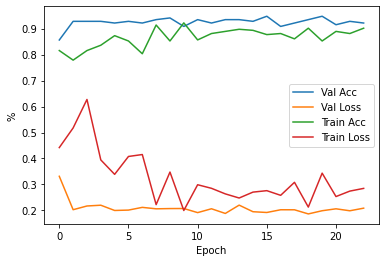

In [41]:
visualize_performance(train_loss_ft,train_acc_ft, val_loss_ft, val_acc_ft)

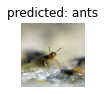

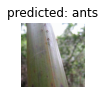

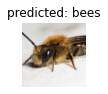

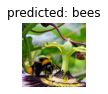

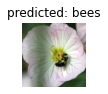

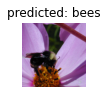

In [11]:
visualize_model(model_ft)

## ConvNet fixed feature extractor

This approach keeps all the weights from the pre-trained ResNet, but adds a blank fully-connected layer on top. Its parameters will be trained to classify our bees and ants.

In [36]:
model_conv = torchvision.models.resnet18(pretrained=True)

# freeze parameters of lower layers
for param in model_conv.parameters():
    param.requires_grad = False

# replace last fc-layer by a fresh one
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv = model_conv.to(device)

# now only parameters of final fc-layer will be optimized 
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
conv_criterion = nn.CrossEntropyLoss()

conv_exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [42]:
# train ResNet 
model_conv, train_loss_conv, train_acc_conv, val_loss_conv, val_acc_conv = train_model(model_conv, conv_criterion, 
                         optimizer_conv, conv_exp_lr_scheduler, num_epochs=25, path='conv_ant_bees.pt')

Epoch 7/25
----------
train Loss: 0.5401 Acc: 0.7664
val Loss: 0.1715 Acc: 0.9608

Epoch 8/25
----------
train Loss: 0.4928 Acc: 0.7869
val Loss: 0.2809 Acc: 0.8954

Epoch 9/25
----------
train Loss: 0.6048 Acc: 0.7664
val Loss: 0.3523 Acc: 0.8758

Epoch 10/25
----------
train Loss: 0.4367 Acc: 0.8115
val Loss: 0.2469 Acc: 0.9412

Epoch 11/25
----------
train Loss: 0.3325 Acc: 0.8648
val Loss: 0.1861 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.4167 Acc: 0.8402
val Loss: 0.2045 Acc: 0.9542

Epoch 13/25
----------
train Loss: 0.3873 Acc: 0.8361
val Loss: 0.1873 Acc: 0.9542

Epoch 14/25
----------
train Loss: 0.3439 Acc: 0.8279
val Loss: 0.1811 Acc: 0.9477

Epoch 15/25
----------
train Loss: 0.3125 Acc: 0.8566
val Loss: 0.1888 Acc: 0.9477

Epoch 16/25
----------
train Loss: 0.3339 Acc: 0.8566
val Loss: 0.1773 Acc: 0.9608

Epoch 17/25
----------
train Loss: 0.3371 Acc: 0.8566
val Loss: 0.1832 Acc: 0.9542

Epoch 18/25
----------
train Loss: 0.2944 Acc: 0.8730
val Loss: 0.1919 Acc: 0.9

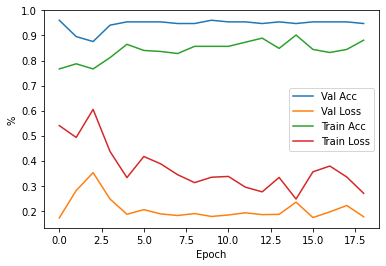

In [43]:
visualize_performance(train_loss_conv,train_acc_conv, val_loss_conv, val_acc_conv)

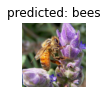

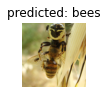

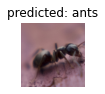

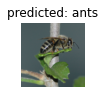

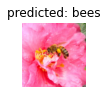

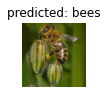

In [44]:
visualize_model(model_conv)